In [127]:
import numpy as np
import json
from matplotlib import pyplot as plt
import os
import Hamiltonians.helper as helper
import Hamiltonians.hamiltonians as ham
from sklearn.cluster import DBSCAN

plt.rcParams['figure.dpi'] = 150
system = "linear_4"
keys = ["run"+str(i) for i in range(1,2)]
colors = ["steelblue","g","gray"]
n_points = 0
for i in range(len(keys)):
    dir_path = keys[i] +"/results"
    n_points += len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))])
data = {"mix_energy": [], "mix_shots": [],"mix_moments":[], "qwc_energy": [], "qwc_shots":[],"qwc_moments":[], "cs_energy":[], "cs_shots":[],"cs_moments":[]}

In [128]:
data

{'mix_energy': [],
 'mix_shots': [],
 'mix_moments': [],
 'qwc_energy': [],
 'qwc_shots': [],
 'qwc_moments': [],
 'cs_energy': [],
 'cs_shots': [],
 'cs_moments': []}

<h1> Step 1) Collect and Organize Results </h1>

In [129]:
with open("saved_hamiltonians/linear_4_1.json") as fp:
    k = json.load(fp)
ham_qm = ham.Hamiltonian(list(k.keys()), [complex(s) for s in list(k.values())])

In [130]:
ham_mat = ham_qm.to_matrix()

In [131]:
n_points

120

In [132]:
for j in range(len(keys)):
    dir_path = keys[j] +"/results"
    nps = len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))])
    for i in range(nps):
        with open(dir_path+"/"+str(i)+".json") as fp:
            dat_ = json.load(fp)
            for key in data:
                data[key] += [dat_[key]]

In [133]:
for key in data:
    data[key] = np.array(data[key]).T

**Remove Outliers Using DBSCAN Protocol ($\epsilon = 5$, $minsamples = 5$)**

In [134]:
data["mix_energy"].shape

(5, 120)

In [135]:
ks = [1,2,3,4,5]
data_no_outliers = {"mix_energy": [], "mix_shots": [],"mix_moments":[], "qwc_energy": [], "qwc_shots":[],"qwc_moments":[], "cs_energy":[], "cs_shots":[],"cs_moments":[]}
data_no_outliers_save = {"mix_energy": [], "mix_shots": [],"mix_moments":[], "qwc_energy": [], "qwc_shots":[],"qwc_moments":[], "cs_energy":[], "cs_shots":[],"cs_moments":[]}
for key in ["mix_energy", "cs_energy","qwc_energy"]:
    data_no_outliers[key] = [0]*len(ks)
    data_no_outliers_save[key] = [0]*len(ks)
    for i in range(len(ks)):
        X = np.array(data[key][i]).reshape(-1,1)
        clustering = DBSCAN(eps=5, min_samples=5).fit(X)
        clustering.labels_
        Y = np.array([np.inf]*len(X))
        indeces = np.where(clustering.labels_ != -1)[0]
        Y[indeces] = X[indeces].reshape(1,-1)[0]

        data_no_outliers[key][i] = X[indeces].reshape(1,-1)[0]
        data_no_outliers_save[key][i] = Y

In [136]:
import pandas as pd

row_names = {"system":[], "method":[], "shots":[], "computer":[]}
for i in range(ks[-1]*2):
    row_names["Moment " + str(i)] = []
for k in ks:
    row_names["PDS " + str(k)] = []
df = pd.DataFrame(row_names)
print(df)
from tqdm import tqdm
for key_ in ["mix", "qwc", "cs"]:
    for i in tqdm(range(n_points)):
        row = [system, key_,data[key_+"_shots"][i],"qasm simulator"]
        for j in range(ks[-1]*2):
            row += [complex(data[key_+"_moments"][j][i]).real]
        for k in range(len(ks)):
            row += [complex(data[key_+"_energy"][k][i]).real]
        df.loc[len(df.index)] = row
print(df)
df.to_csv('results.csv', index=False)


Empty DataFrame
Columns: [system, method, shots, computer, Moment 0, Moment 1, Moment 2, Moment 3, Moment 4, Moment 5, Moment 6, Moment 7, Moment 8, Moment 9, PDS 1, PDS 2, PDS 3, PDS 4, PDS 5]
Index: []


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 166.49it/s]

       system method  shots        computer  Moment 0  Moment 1  Moment 2  \
0    linear_4    mix  21504  qasm simulator       1.0  1.583333  7.625000   
1    linear_4    mix  21504  qasm simulator       1.0  1.649740  6.872396   
2    linear_4    mix  21504  qasm simulator       1.0  1.630208  7.260417   
3    linear_4    mix  21504  qasm simulator       1.0  1.584635  7.239583   
4    linear_4    mix  21504  qasm simulator       1.0  1.473958  7.151042   
..        ...    ...    ...             ...       ...       ...       ...   
355  linear_4     cs  21465  qasm simulator       1.0  1.647077  7.336890   
356  linear_4     cs  21465  qasm simulator       1.0  1.640360  7.189363   
357  linear_4     cs  21465  qasm simulator       1.0  1.614977  6.497463   
358  linear_4     cs  21465  qasm simulator       1.0  1.504754  7.414423   
359  linear_4     cs  21465  qasm simulator       1.0  1.683149  6.731958   

      Moment 3    Moment 4    Moment 5     Moment 6      Moment 7  \
0     

In [137]:
import pandas as pd
from tqdm import tqdm
row_names = {"system":[], "method":[], "shots":[], "computer":[]}
for k in ks:
    row_names["PDS " + str(k)] = []
df = pd.DataFrame(row_names)

for key_ in ["mix", "qwc", "cs"]:
    for i in tqdm(range(n_points)):
        row = [system, key_,data[key_+"_shots"][i],"qasm simulator"]
        
        for k in range(len(ks)):
            if(data_no_outliers_save[key_+"_energy"][k][i] == np.inf):
                row += ["X"]
            else:
                row += [data_no_outliers_save[key_+"_energy"][k][i]]
        df.loc[len(df.index)] = row
print(df)
df.to_csv('results_no_outliers.csv', index=False)


100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 228.03it/s]


       system method  shots        computer     PDS 1     PDS 2     PDS 3  \
0    linear_4    mix  21504  qasm simulator  1.583333 -3.778130 -5.419936   
1    linear_4    mix  21504  qasm simulator  1.649740 -3.121791  -5.26327   
2    linear_4    mix  21504  qasm simulator  1.630208 -3.501724 -5.535746   
3    linear_4    mix  21504  qasm simulator  1.584635 -3.567339 -5.390666   
4    linear_4    mix  21504  qasm simulator  1.473958 -3.349210 -5.253423   
..        ...    ...    ...             ...       ...       ...       ...   
355  linear_4     cs  21465  qasm simulator  1.647077 -3.692545 -5.510384   
356  linear_4     cs  21465  qasm simulator  1.640360 -3.417450 -5.189905   
357  linear_4     cs  21465  qasm simulator  1.614977 -2.618074 -4.802315   
358  linear_4     cs  21465  qasm simulator  1.504754 -3.617439 -5.495513   
359  linear_4     cs  21465  qasm simulator  1.683149 -2.395298  -2.57608   

        PDS 4     PDS 5  
0   -6.334875 -6.460341  
1   -6.204081 -6.452970

In [138]:
data_no_outliers_save

{'mix_energy': [array([1.58333333, 1.64973958, 1.63020833, 1.58463542, 1.47395833,
         1.625     , 1.54036458, 1.61328125, 1.609375  , 1.5234375 ,
         1.45442708, 1.55208333, 1.61328125, 1.59895833, 1.609375  ,
         1.61067708, 1.58854167, 1.63151042, 1.54817708, 1.64713542,
         1.56640625, 1.60026042, 1.5234375 , 1.59114583, 1.70963542,
         1.65885417, 1.58854167, 1.59895833, 1.5       , 1.63541667,
         1.61979167, 1.55989583, 1.60677083, 1.65234375, 1.68489583,
         1.66015625, 1.4921875 , 1.67708333, 1.56770833, 1.63671875,
         1.68489583, 1.57161458, 1.65625   , 1.63802083, 1.60677083,
         1.65234375, 1.63411458, 1.44921875, 1.703125  , 1.53255208,
         1.578125  , 1.62890625, 1.64453125, 1.64583333, 1.67708333,
         1.51041667, 1.52734375, 1.53385417, 1.5234375 , 1.61197917,
         1.58984375, 1.53515625, 1.61197917, 1.61197917, 1.71614583,
         1.52083333, 1.59114583, 1.609375  , 1.67708333, 1.49869792,
         1.5546875 ,

<h1> Step 2) Visualize Data </h1>

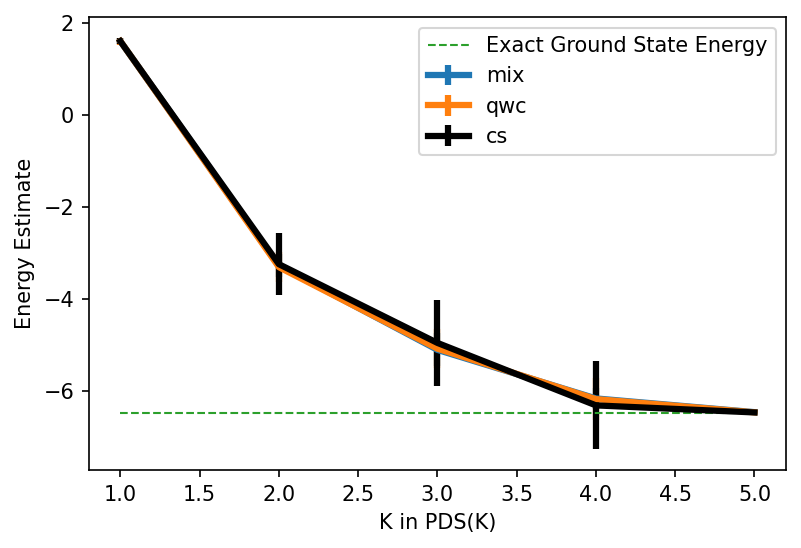

In [139]:
plt.errorbar(ks, [np.mean(data_no_outliers["mix_energy"][i]) for i in range(len(ks))], 
             yerr=[np.std(data_no_outliers["mix_energy"][i]) for i in range(len(ks))], lw =3, label="mix")
plt.errorbar(ks, [np.mean(data_no_outliers["qwc_energy"][i]) for i in range(len(ks))], 
             yerr=[np.std(data_no_outliers["qwc_energy"][i]) for i in range(len(ks))], lw =3, label="qwc")
plt.errorbar(ks, [np.mean(data_no_outliers["cs_energy"][i]) for i in range(len(ks))], 
             yerr=[np.std(data_no_outliers["cs_energy"][i]) for i in range(len(ks))], lw = 3, color="black", label="cs")
min_e = np.min(np.linalg.eigh(ham_mat)[0])
plt.plot(ks,[min_e]*len(ks),lw = 1, linestyle="dashed", label="Exact Ground State Energy")
plt.legend()
plt.xlabel("K in PDS(K)")
plt.ylabel("Energy Estimate")
plt.savefig("figures/energy_"+system+".jpg")

Looks pretty good! A prettier version of the plot will follow.

(21511.8, 0)


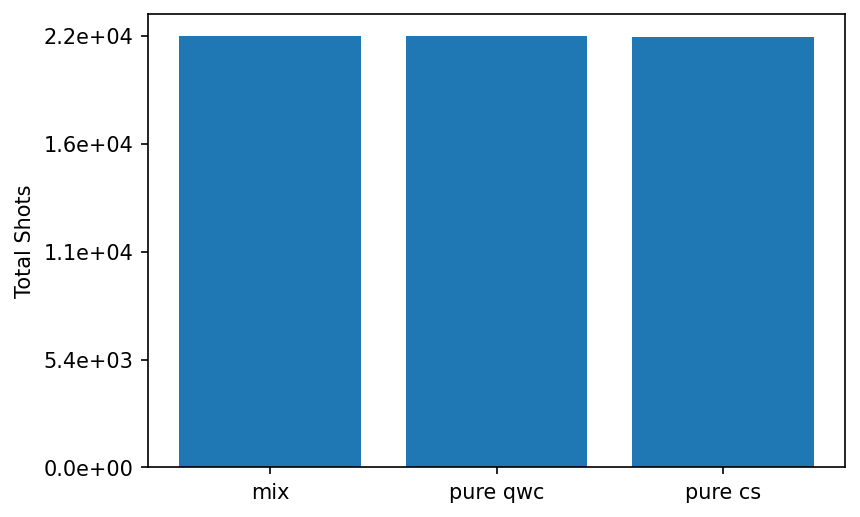

In [140]:
plt.bar(["mix","pure qwc","pure cs"],[data["mix_shots"].mean(), data["qwc_shots"].mean(), data["cs_shots"].mean()])
def get_ticks_shots(data_, p=35, n_ticks=5):
    # helper function to scale y-axis nicely
    max_ = -1000
    d1 = [np.mean(data_["mix_shots"][i]) for i in range(len(ks))] 
    d2 = [np.mean(data_["qwc_shots"][i]) for i in range(len(ks))]
    d3 = [np.mean(data_["cs_shots"][i]) for i in range(len(ks))] 
    max_ = max(max(d1), max(d2), max(d3))
    min_ = min(min(d1), min(d2), min(d3))
    bounds = (max_ + (0.01 * p) * (max_-min_), 0)
    print(bounds)
    ticks = np.linspace(bounds[0], bounds[1], n_ticks+2)
    return ticks
import matplotlib.ticker as mtick
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))

sticks = get_ticks_shots(data,20,3)
plt.yticks(sticks)
plt.ylabel("Total Shots")
plt.savefig("figures/shots_"+system+".jpg")

**Set up analytical version of the system to calculate exact PDS(K) for comparison to moment mixing scheme**

In [141]:
n_qubits = 4
K = 5
ket0 = np.array([1.,0.],dtype=complex)
ket1 = np.array([0.,1.],dtype=complex)


PauliX = np.array([[0.,1.],[1.,0]], dtype=complex)
PauliY = np.array([[0.,-1.j],[1.j,0]], dtype=complex)
PauliZ = np.array([[1.0,0.],[0.,-1.]], dtype=complex)
PauliI = np.eye(2, dtype=complex)
PauliVec = [PauliX, PauliY, PauliZ]
cz = np.eye(4)
cz[3,3] = -1
PauliDict = {"Identity": "I", "PauliX": "X", "PauliY": "Y", "PauliZ": "Z"}
PauliNumToLetter = {0: "X", 1: "Y", 2: "Z"}
PauliDict_2 = {"I": PauliI, "X": PauliX, "Y": PauliY, "Z": PauliZ}
Hadamard = (1/np.sqrt(2)) * np.array([[1,1],[1,-1]])
CNOT = np.eye(4)
CNOT[3,3]=0
CNOT[2,2] = 0 
CNOT[3,2] = 1
CNOT[2,3] = 1
thetaTest = [-2,1]
cz = np.eye(4)
cz[3,3] = -1


"""

====================
FUNCTION DEFINITIONS
++++++++++++++++++++


"""

def RY(theta):
    '''
        matrix representation of the RY gate in the Z computational basis
    '''
    matrix = np.zeros((2,2),dtype=complex)
    matrix[0,0] = np.cos(theta/2)
    matrix[1,1] = np.cos(theta/2)
    matrix[0,1] = -np.sin(theta/2)
    matrix[1,0] =  np.sin(theta/2)
    return matrix
def RZ(theta):
    matrix = np.zeros((2,2), dtype=complex)
    matrix[0,0] = np.exp(-1.j * theta/2)
    matrix[1,1] = np.exp(1.j * theta/2)
    return matrix
def linear_hamiltonian_matrix_dict(j,u,b=1.0,n=10):
    '''
        represent our Hamiltonian as a matrix
    '''
    combos = list(combinations([int(i) for i in range(n)],2))
    H = {}
    for i in range(n-1):
        next_ = i+1

        for k in range(3):
            A = ["I" for i in range(n)]
            A[i] = PauliNumToLetter[k]
            A[next_] = PauliNumToLetter[k]
            x = j
            if(k==2):
                x = u
            H["".join(A)] = x
    return H

def linear_hamiltonian_matrix(j,u,b=1.0,n=10):
    '''
        represent our Hamiltonian as a matrix
    '''
    combos = list(combinations([int(i) for i in range(n)],2))
    H = np.zeros((2**n, 2**n), dtype=complex)
    for i in range(n-1):
        next_ = i+1

        for k in range(3):
            A = [PauliI for i in range(n)]
            A[i] = PauliVec[k]
            A[next_] = PauliVec[k]
            x = j
            if(k==2):
                x = u
            add = [1]
            for qbit in range(n):
                
                add = np.kron(add, A[qbit])
            H += x*add
    return H

def circuit(theta):
    qc = qm.QuantumCircuit(n_qubits,n_qubits)
    for w in range(n_qubits-1):
        qc.h(w)
        qc.ry(theta[w], w)
    for w in range(n_qubits-1):
        qc.cnot(w, w+1)
    for w in range(n_qubits):
        qc.rz(theta[w + n_qubits], w)
    return qc

def circuit_numerical(theta):
    psi = np.zeros(2 ** n_qubits)
    print(2**n_qubits)
    psi[0] = 1 # initialize in |0000....000>
    for w in range(n_qubits-1):
        obs_ = [1]
        for i in range(n_qubits):
            if not i == w:
                obs_ = np.kron(obs_, PauliI)
            else:
                obs_ = np.kron(obs_, Hadamard)
        psi = obs_ @ psi 
        obs_ = [1]
        for i in range(n_qubits):
            if not i == w:
                obs_ = np.kron(obs_, PauliI)
            else:
                obs_ = np.kron(obs_, RY(theta[w]))
        psi = obs_ @ psi 
    for w in range(n_qubits-1):
        obs_ = [1]
        for i in range(n_qubits):
            if not i == w and not i == w+1:
                obs_ = np.kron(obs_, PauliI)
            elif i == w:
                obs_ = np.kron(obs_, CNOT)
            elif i == w+1:
                pass;
            
        psi = obs_ @ psi
    for w in range(n_qubits):
        obs_ = [1]
        for i in range(n_qubits):
            if not i == w:
                obs_ = np.kron(obs_, PauliI)
            else:
                obs_ = np.kron(obs_, RZ(theta[w+n_qubits]))
        psi = obs_ @ psi
    return psi



def tildeM(e_dict, K):
    M = np.zeros((K,K), dtype=complex)
    for i in range(1,K+1):
        for j in range(1,K+1):
            M[i-1,j-1] = e_dict[int(2*K-i-j)]
    return M

def tildeY(e_dict, K):
    Y = np.zeros(K, dtype=complex)
    for i in range(1,K+1):
        Y[i-1] = e_dict[int(2*K-i)]
    return Y
def comp_energy(moments, K):
    M_ = tildeM(moments, K)
    Y_ = tildeY(moments, K)
    X_ = np.linalg.lstsq(M_, -Y_,rcond=None)[0]
    coeffs = np.ones(K+1)
    for k in range(1,K+1):
        coeffs[k] = X_[k-1].real
    return np.min(np.roots(coeffs)).real

In [142]:
theta_test = np.genfromtxt(keys[0]+"/theta_4_save.txt") # load the rotation used to prepare the ansatz
                                                        # all rotations for each run is are the same
                                                        # here we use the first run, however it shouldn't matter
psi_numerical = circuit_numerical(theta_test)

16


In [143]:
exps = {}
for i in range(2*K):
    with open("saved_hamiltonians/linear_4_"+str(i)+".json") as fp:
        k = json.load(fp)
        for key in k:
            if key not in exps:
                exps[key] = np.conjugate(psi_numerical).T @ ham.Hamiltonian([key],[1]).to_matrix() @ psi_numerical

In [147]:

def lettersToNums(l):
    # some simple helper func to convert the pauli strings
    # into the form that the shadows use
    numsL = []
    for i in l:
        if(i == "X"):
            numsL += [0]
        elif(i == "Y"):
            numsL += [1]
        elif(i == "Z"):
            numsL += [2]
        else:
            numsL += [3]
    return numsL


In [148]:
def estimate_shadow_observable_fast(shadow, target_obs, k=10):
    '''Estimate the expectation value of an observabley,
    with k median of means chunks'''
    means = []
    snap, obs = shadow
    chunk_size = len(snap) // k
    pauli_locations = [i for i in range(len(target_obs)) if target_obs[i] != 3]
    tobs = target_obs[pauli_locations]
    snap2 = snap[:,pauli_locations]
    obs2 = obs[:,pauli_locations]
    nper = int(np.floor(len(obs) / k))
    num_per_max = [nper] * k
    num_per_max[-1] = len(snap) - nper * (k - 1)
    for i in range(k):
        snap_chunk, obs_chunk = (
            snap2[i * nper : i *nper + num_per_max[i]],
            obs2[i * nper : i *nper + num_per_max[i]],
        )
        indices = np.all(obs_chunk == tobs, axis=1)
        if sum(indices) > 0:
            means += [np.sum(np.prod(snap_chunk[indices], axis=1))/sum(indices)]
        else:
            means += [0]
    return np.median(means)

In [149]:
moments = {i: np.conjugate(psi_numerical).T @ np.linalg.matrix_power(ham_qm.to_matrix(), i) @ psi_numerical for i in range(0,15)}

In [150]:
print("Exact Moments:")
print(moments)

Exact Moments:
{0: (0.9999999999999992+0j), 1: (1.834539393472253+1.1102230246251565e-16j), 2: (6.906370356644367-4.440892098500626e-16j), 3: (10.198326596526407+0j), 4: (82.96376489988322+0j), 5: (-60.75419303790294+0j), 6: (1659.2518551397443-1.4210854715202004e-14j), 7: (-6403.974326895098+0j), 8: (52199.70294360146-2.7284841053187847e-12j), 9: (-297038.7342452046+0j), 10: (2010171.9956264729+5.820766091346741e-11j), 11: (-12605743.085313888+2.3283064365386963e-10j), 12: (82196009.85637514-1.862645149230957e-09j), 13: (-527457140.50259906+0j), 14: (3414495976.7540355+0j)}


In [151]:
def moment(n, e_dict_, ham_):
    e = 0
    for i in range(len(ham_.letters)):
        e += ham_.coeffs[i] * e_dict_[ham_.letters[i]]
    return e

In [152]:
ks = [i for i in range(1, K+1)]
es = []
for k in ks:
    es += [comp_energy(moments, k)]

In [153]:
exact_pds = es
print(exact_pds)

[1.8345393934722545, -3.2315224148889676, -5.572883896037126, -6.320518095875549, -6.459961996640277]


**Calculate errors for moment mix runs**

In [154]:
errors = {}
errors["mix_energy"] = [0]*len(ks)
errors["cs_energy"] = [0]*len(ks)
errors["qwc_energy"] = [0]*len(ks)
for j in range(len(ks)):
    errors["mix_energy"][j] = np.abs(np.array(data_no_outliers["mix_energy"][j])-exact_pds[j])
    errors["cs_energy"][j] = np.abs(np.array(data_no_outliers["cs_energy"][j])-exact_pds[j])
    errors["qwc_energy"][j] = np.abs(np.array(data_no_outliers["qwc_energy"][j])-exact_pds[j])


In [155]:
def get_ticks(data_, p=35, n_ticks=5):
    max_ = -1000
    d1 = [np.mean(data_["mix_energy"][i]) for i in range(len(ks))] 
    d2 = [np.mean(data_["qwc_energy"][i]) for i in range(len(ks))]
    d3 = [np.mean(data_["cs_energy"][i]) for i in range(len(ks))] 
    max_ = max(max(d1), max(d2), max(d3))
    min_ = min(min(d1), min(d2), min(d3))
    bounds = (max_ + (0.01 * p) * (max_-min_), min_ - (0.01 * p) * (max_-min_))
    print(bounds)
    ticks = np.linspace(bounds[0], bounds[1], n_ticks+2)
    return ticks

In [156]:
ticks = get_ticks(data_no_outliers)
eticks = get_ticks(errors, 130)
print(eticks)

(4.426879048544597, -9.280117922362496)
(1.7727052010460014, -0.9889446824265082)
[ 1.7727052   1.31243022  0.85215524  0.39188026 -0.06839472 -0.5286697
 -0.98894468]


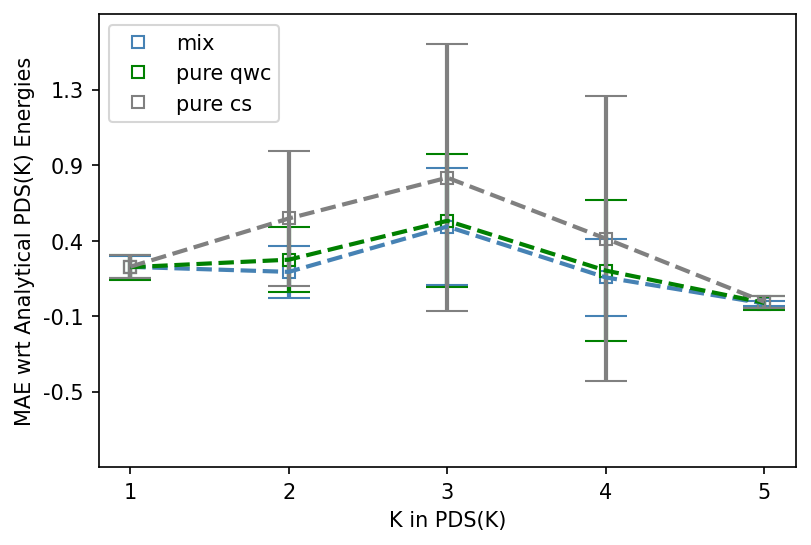

In [157]:
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import StrMethodFormatter
fig, ax1 = plt.subplots()
ax1.errorbar(ks, [np.mean(np.abs(errors["mix_energy"][i])) for i in range(len(ks))],
             yerr=[np.std(np.abs(errors["mix_energy"][i])) for i in range(len(ks))],
             capsize=10,lw =2,ls="dashed", color=colors[0])
ax1.plot(ks, [np.mean(np.abs(errors["mix_energy"][i])) for i in range(len(ks))],
          marker='s', color=colors[0],linestyle="none",fillstyle='none',label="mix")
ax1.errorbar(ks, [np.mean(np.abs(errors["qwc_energy"][i])) for i in range(len(ks))],
             yerr=[np.std(np.abs(errors["qwc_energy"][i])) for i in range(len(ks))],
             capsize=10,lw =2,ls="dashed", color=colors[1])
ax1.plot(ks, [np.mean(np.abs(errors["qwc_energy"][i])) for i in range(len(ks))],
          marker='s', color=colors[1],linestyle="none",fillstyle='none',label="pure qwc")
ax1.errorbar(ks, [np.mean(np.abs(errors["cs_energy"][i])) for i in range(len(ks))],
             yerr=[np.std(np.abs(errors["cs_energy"][i])) for i in range(len(ks))],
             capsize=10,lw =2,ls="dashed", color=colors[2])
ax1.plot(ks, [np.mean(np.abs(errors["cs_energy"][i])) for i in range(len(ks))],
          marker='s', color=colors[2],linestyle="none",fillstyle='none',label="pure cs")
ax1.set_xticks([1,2,3,4,5])
ax1.set_yticks(eticks[1:-1])
ax1.set_ylim((eticks[-1], eticks[0]))
ax1.legend(loc="upper left")
ax1.set_ylabel("MAE wrt Analytical PDS(K) Energies")
ax1.set_xlabel("K in PDS(K)")
ax1.yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}')) # 2 decimal places
plt.savefig("figures/mae_pretty_"+system+".jpg")

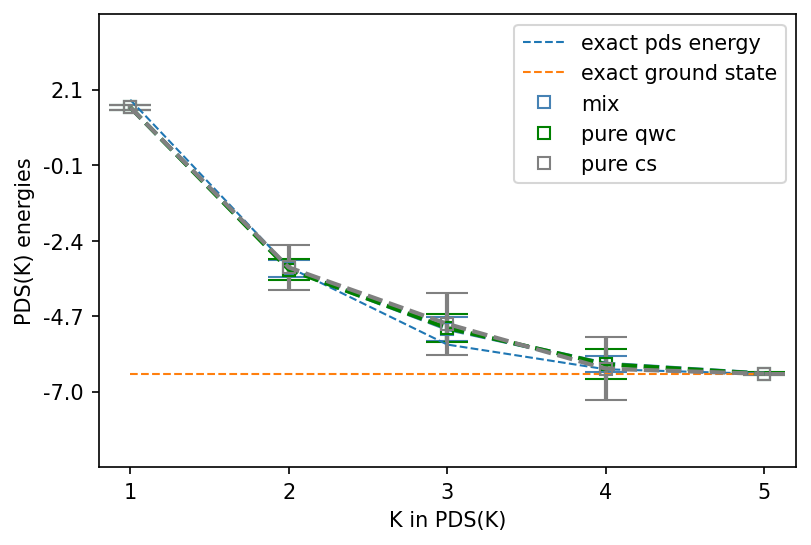

In [158]:
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import StrMethodFormatter

plt.errorbar(ks, [np.mean(data_no_outliers["mix_energy"][i]) for i in range(len(ks))], 
             yerr=[np.std(data_no_outliers["mix_energy"][i]) for i in range(len(ks))], lw =2, ls="dashed", capsize=10, color=colors[0])
plt.errorbar(ks, [np.mean(data_no_outliers["mix_energy"][i]) for i in range(len(ks))], marker="s", fillstyle="none",ls="none",label="mix", color=colors[0])
plt.errorbar(ks, [np.mean(data_no_outliers["qwc_energy"][i]) for i in range(len(ks))], 
             yerr=[np.std(data_no_outliers["qwc_energy"][i]) for i in range(len(ks))], lw =2, ls="dashed", capsize=10, color=colors[1])
plt.errorbar(ks, [np.mean(data_no_outliers["qwc_energy"][i]) for i in range(len(ks))], marker="s", fillstyle="none",ls="none",label="pure qwc", color=colors[1])
plt.errorbar(ks, [np.mean(data_no_outliers["cs_energy"][i]) for i in range(len(ks))], 
             yerr=[np.std(data_no_outliers["cs_energy"][i]) for i in range(len(ks))], lw =2, ls="dashed", capsize=10, color=colors[2])
plt.errorbar(ks, [np.mean(data_no_outliers["cs_energy"][i]) for i in range(len(ks))], marker="s", fillstyle="none",ls="none",label="pure cs", color=colors[2])
plt.plot(ks,exact_pds,lw = 1, linestyle="dashed", label="exact pds energy")
plt.plot(ks,[min_e]*len(ks),lw = 1, linestyle="dashed", label="exact ground state")
plt.legend()
plt.xticks([1,2,3,4,5])
plt.ylim((ticks[-1], ticks[0]))
plt.xlabel("K in PDS(K)")
plt.ylabel("PDS(K) energies")
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}')) # 2 decimal places
plt.yticks(ticks[1:-1])
min_e = np.min(np.linalg.eigh(ham_mat)[0])
plt.savefig("figures/energy_pretty_"+system+".jpg")

** some extra code to analyze the moment estimations for each method

/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


[0, 0.0, (1+0j), (1+0j)]


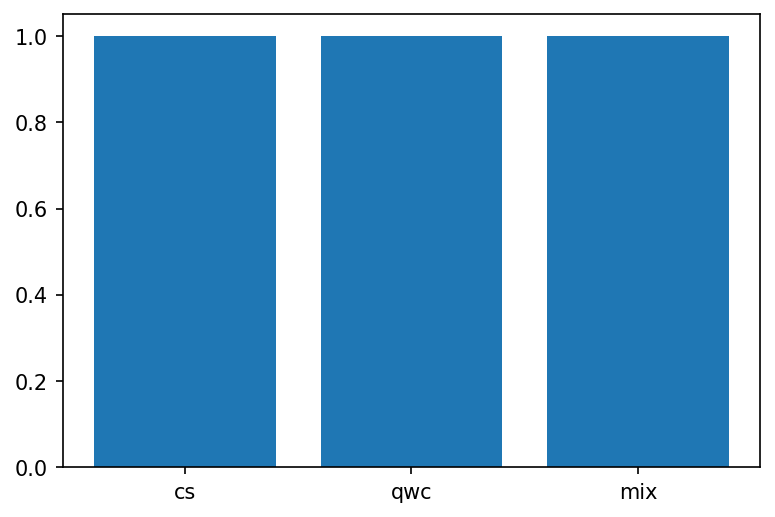

/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


[1, 0.06873390609218905, (1.6048502604166666+0j), (1.6029188368055554+0j)]


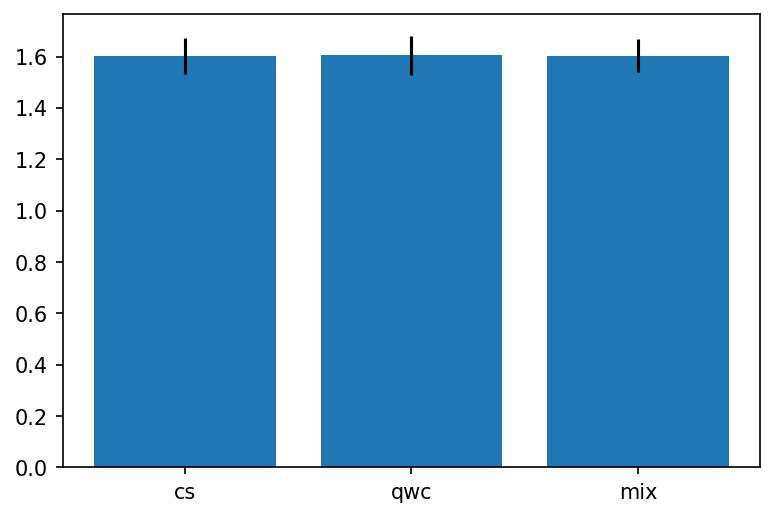

/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


[2, 0.4778295839224575, (7.111848958333333+0j), (7.060633680555556+0j)]


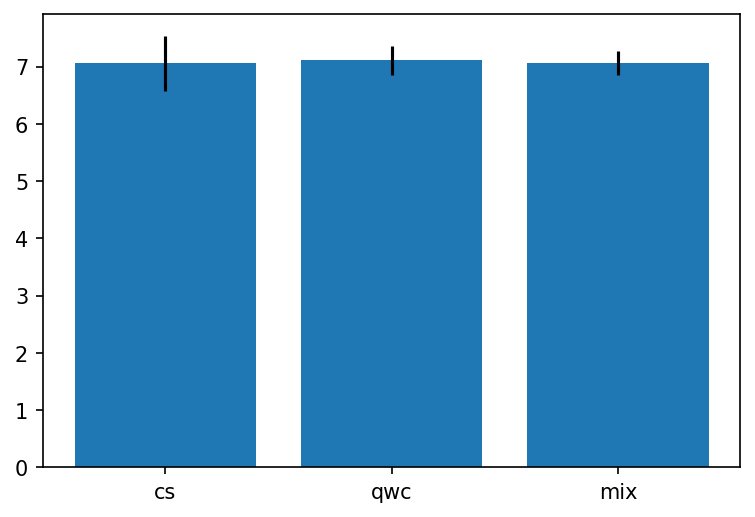

/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


[3, 2.9091379968146542, (7.775358072916666+0j), (7.87202907986111+0j)]


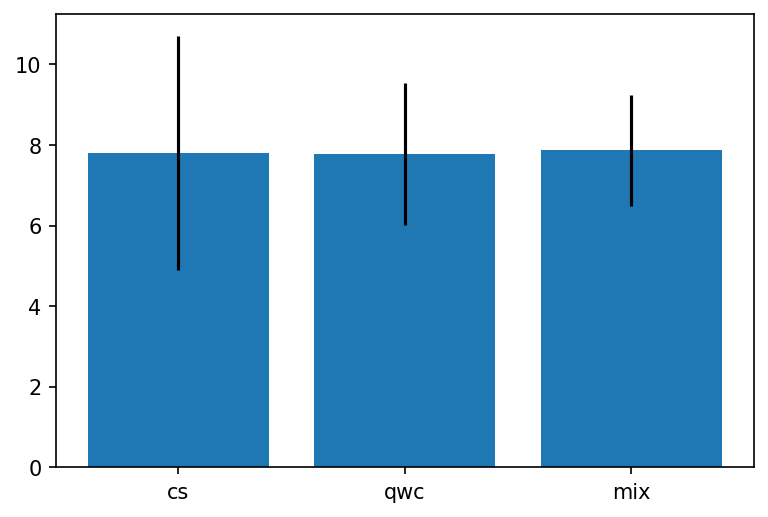

[4, 22.008688884278225, (85.59973958333333+0j), (84.59715277777778+0j)]


/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


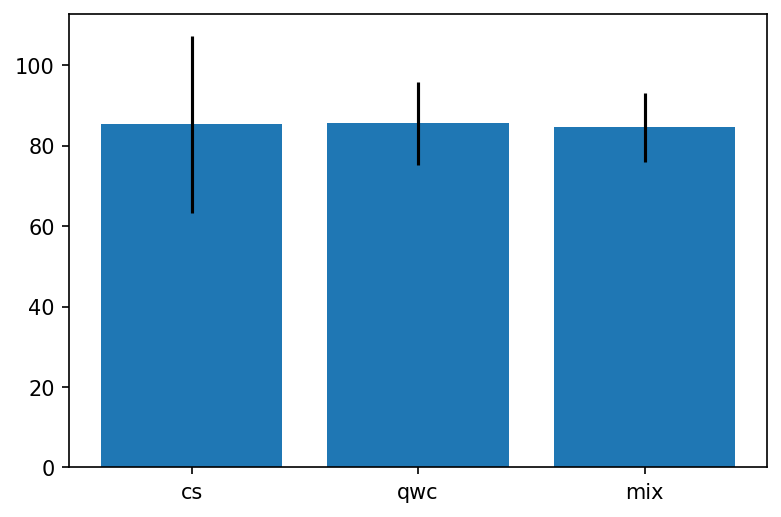

[5, 143.8710132638116, (-84.81637369791666+0j), (-81.13549262152776+0j)]


/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


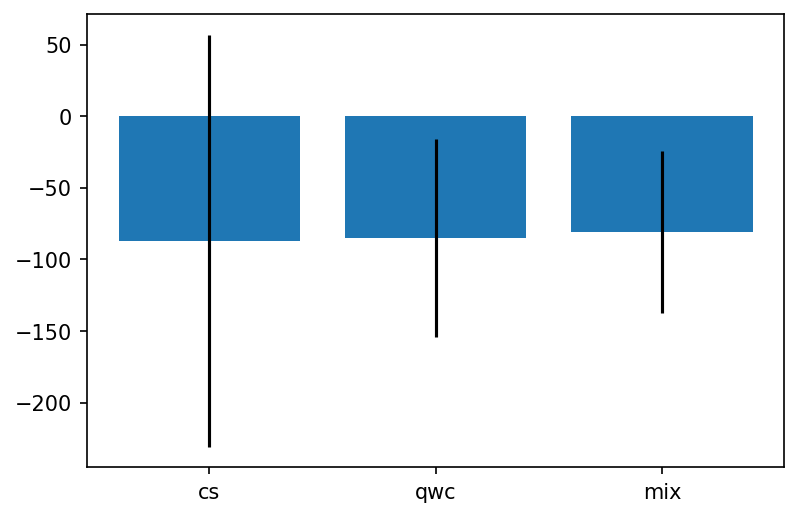

[6, 972.9562190386266, (1664.9110677083333+0j), (1639.010703125+0j)]


/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


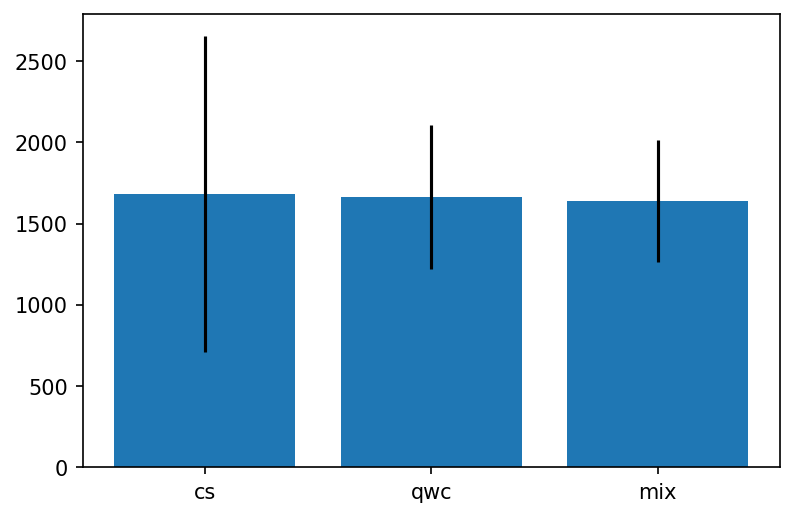

/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


[7, 6349.427757316877, (-6413.13232421875+0j), (-6276.9799587673615+0j)]


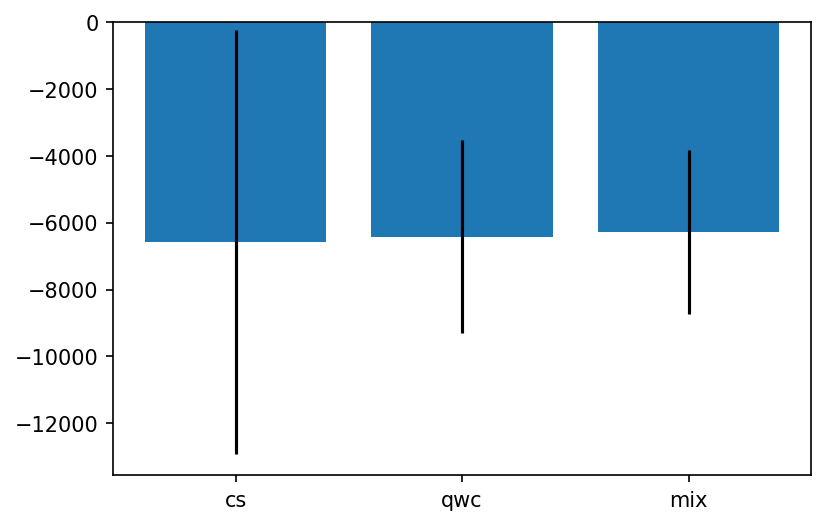

[8, 41604.045854105636, (50489.6265625+0j), (49610.35326388889+0j)]


/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


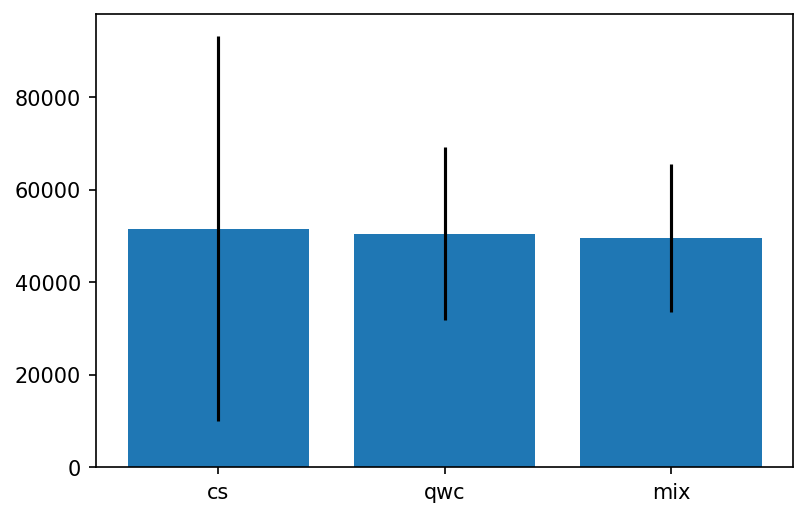

/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


[9, 270116.5544514447, (-284254.4761393229+0j), (-278932.897515191+0j)]


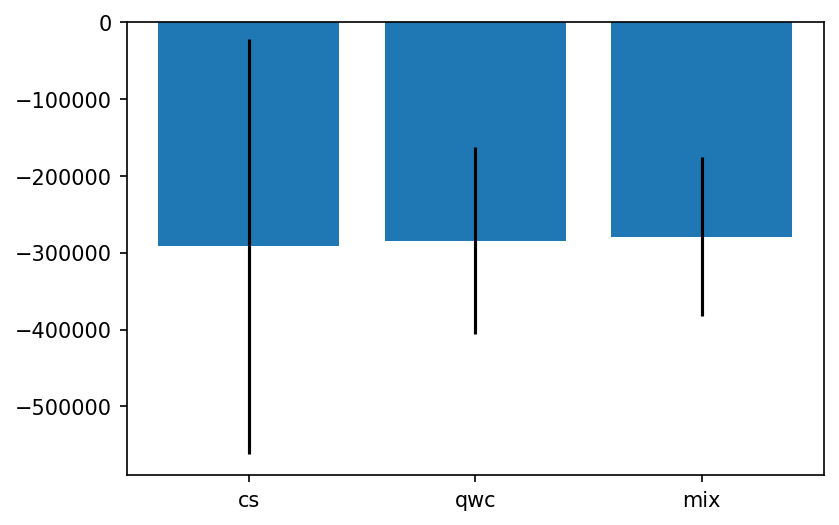

[ 1.00000000e+00+0.j  1.65445502e+00+0.j  7.33134353e+00+0.j
  7.33054243e+00+0.j  9.45901741e+01+0.j -1.36231052e+02+0.j
  2.06300695e+03+0.j -8.96237295e+03+0.j  6.77064459e+04+0.j
 -3.95875214e+05+0.j]
[ 1.00000000e+00+0.j  1.51901743e+00+0.j  7.43866953e+00+0.j
  5.58113656e+00+0.j  9.69188983e+01+0.j -1.54392484e+02+0.j
  2.08051046e+03+0.j -9.02445103e+03+0.j  6.69229177e+04+0.j
 -3.89230930e+05+0.j]
[ 1.00000000e+00+0.j  1.51901743e+00+0.j  7.96973096e+00+0.j
  1.69587732e+00+0.j  1.30919827e+02+0.j -3.86645912e+02+0.j
  3.69781929e+03+0.j -1.97154463e+04+0.j  1.37567529e+05+0.j
 -8.49862780e+05+0.j]
[ 1.00000000e+00+0.j  1.50475436e+00+0.j  7.63074485e+00+0.j
  4.53296305e+00+0.j  1.04551828e+02+0.j -2.00406540e+02+0.j
  2.38682788e+03+0.j -1.09686349e+04+0.j  7.95701082e+04+0.j
 -4.70622108e+05+0.j]
[ 1.00000000e+00+0.j  1.65451664e+00+0.j  7.25990491e+00+0.j
  7.74263099e+00+0.j  8.85296335e+01+0.j -9.54991902e+01+0.j
  1.75482872e+03+0.j -6.91991422e+03+0.j  5.39344715e+04+0

[ 1.00000000e+00+0.j  1.59382855e+00+0.j  7.42394708e+00+0.j
  5.34386309e+00+0.j  1.04647714e+02+0.j -2.18019409e+02+0.j
  2.56963256e+03+0.j -1.24208992e+04+0.j  8.99464119e+04+0.j
 -5.41678933e+05+0.j]
[ 1.00000000e+00+0.j  1.64707698e+00+0.j  7.33688966e+00+0.j
  6.63045852e+00+0.j  9.65622878e+01+0.j -1.55367062e+02+0.j
  2.15827950e+03+0.j -9.63276099e+03+0.j  7.17469242e+04+0.j
 -4.22395130e+05+0.j]
[ 1.00000000e+00+0.j  1.64036001e+00+0.j  7.18936264e+00+0.j
  7.79994659e+00+0.j  8.69717428e+01+0.j -9.08793602e+01+0.j
  1.71425576e+03+0.j -6.71639759e+03+0.j  5.25373738e+04+0.j
 -2.97411677e+05+0.j]
[ 1.00000000e+00+0.j  1.61497666e+00+0.j  6.49746347e+00+0.j
  1.01653817e+01+0.j  6.95638228e+01+0.j  4.92147030e+00+0.j
  1.10267911e+03+0.j -2.93491424e+03+0.j  2.83799490e+04+0.j
 -1.43370998e+05+0.j]
[ 1.00000000e+00+0.j  1.50475436e+00+0.j  7.41442342e+00+0.j
  5.45450556e+00+0.j  1.00262530e+02+0.j -1.81498992e+02+0.j
  2.29451345e+03+0.j -1.04995330e+04+0.j  7.69916114e+04+0

/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


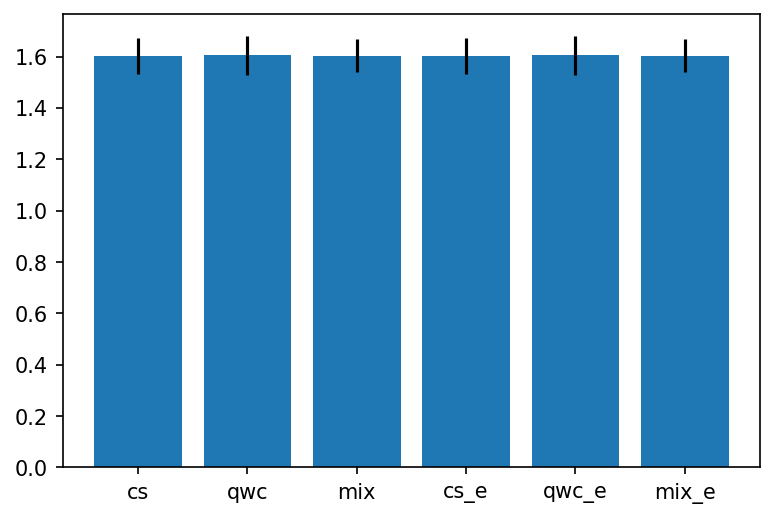

[ 1.00000000e+00+0.j  1.65445502e+00+0.j  7.33134353e+00+0.j
  7.33054243e+00+0.j  9.45901741e+01+0.j -1.36231052e+02+0.j
  2.06300695e+03+0.j -8.96237295e+03+0.j  6.77064459e+04+0.j
 -3.95875214e+05+0.j]
[ 1.00000000e+00+0.j  1.51901743e+00+0.j  7.43866953e+00+0.j
  5.58113656e+00+0.j  9.69188983e+01+0.j -1.54392484e+02+0.j
  2.08051046e+03+0.j -9.02445103e+03+0.j  6.69229177e+04+0.j
 -3.89230930e+05+0.j]
[ 1.00000000e+00+0.j  1.51901743e+00+0.j  7.96973096e+00+0.j
  1.69587732e+00+0.j  1.30919827e+02+0.j -3.86645912e+02+0.j
  3.69781929e+03+0.j -1.97154463e+04+0.j  1.37567529e+05+0.j
 -8.49862780e+05+0.j]
[ 1.00000000e+00+0.j  1.50475436e+00+0.j  7.63074485e+00+0.j
  4.53296305e+00+0.j  1.04551828e+02+0.j -2.00406540e+02+0.j
  2.38682788e+03+0.j -1.09686349e+04+0.j  7.95701082e+04+0.j
 -4.70622108e+05+0.j]
[ 1.00000000e+00+0.j  1.65451664e+00+0.j  7.25990491e+00+0.j
  7.74263099e+00+0.j  8.85296335e+01+0.j -9.54991902e+01+0.j
  1.75482872e+03+0.j -6.91991422e+03+0.j  5.39344715e+04+0

 -4.16736808e+05+0.j]
[ 1.00000000e+00+0.j  1.54016555e+00+0.j  7.24613483e+00+0.j
  7.95349593e+00+0.j  8.13228706e+01+0.j -4.30790414e+01+0.j
  1.34701089e+03+0.j -4.15878423e+03+0.j  3.51962946e+04+0.j
 -1.82516361e+05+0.j]
[ 1.00000000e+00+0.j  1.66164818e+00+0.j  6.70792505e+00+0.j
  9.08018358e+00+0.j  7.83271544e+01+0.j -5.83244361e+01+0.j
  1.52053440e+03+0.j -5.74928297e+03+0.j  4.67142318e+04+0.j
 -2.63405893e+05+0.j]
[ 1.00000000e+00+0.j  1.73296355e+00+0.j  6.36133122e+00+0.j
  1.32038031e+01+0.j  5.21144245e+01+0.j  1.33661622e+02+0.j
  2.67594474e+02+0.j  2.62207577e+03+0.j -7.75579046e+03+0.j
  9.21269391e+04+0.j]
[ 1.00000000e+00+0.j  1.55111775e+00+0.j  7.05307353e+00+0.j
  7.16871871e+00+0.j  8.41215032e+01+0.j -8.49278935e+01+0.j
  1.60635036e+03+0.j -6.10606299e+03+0.j  4.78654617e+04+0.j
 -2.67614981e+05+0.j]
[ 1.00000000e+00+0.j  1.65774908e+00+0.j  7.90954146e+00+0.j
  3.40322223e+00+0.j  1.23074217e+02+0.j -3.27150584e+02+0.j
  3.32976058e+03+0.j -1.72665756e+04

/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


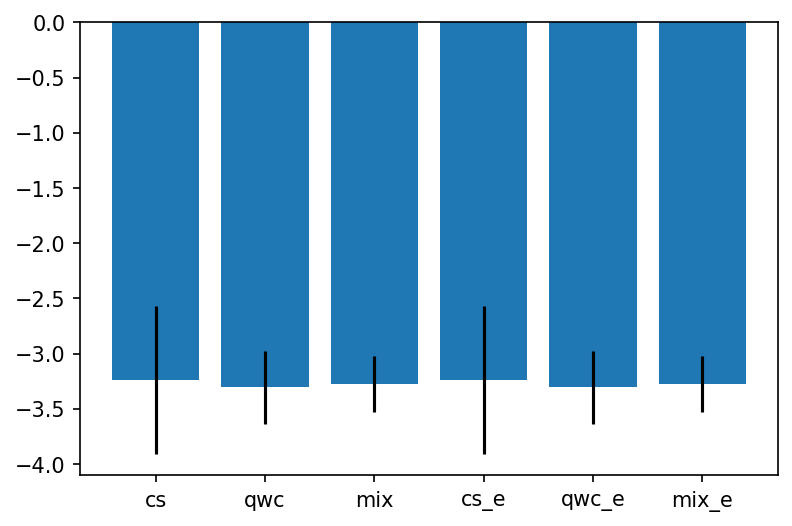

[ 1.00000000e+00+0.j  1.65445502e+00+0.j  7.33134353e+00+0.j
  7.33054243e+00+0.j  9.45901741e+01+0.j -1.36231052e+02+0.j
  2.06300695e+03+0.j -8.96237295e+03+0.j  6.77064459e+04+0.j
 -3.95875214e+05+0.j]
[ 1.00000000e+00+0.j  1.51901743e+00+0.j  7.43866953e+00+0.j
  5.58113656e+00+0.j  9.69188983e+01+0.j -1.54392484e+02+0.j
  2.08051046e+03+0.j -9.02445103e+03+0.j  6.69229177e+04+0.j
 -3.89230930e+05+0.j]
[ 1.00000000e+00+0.j  1.51901743e+00+0.j  7.96973096e+00+0.j
  1.69587732e+00+0.j  1.30919827e+02+0.j -3.86645912e+02+0.j
  3.69781929e+03+0.j -1.97154463e+04+0.j  1.37567529e+05+0.j
 -8.49862780e+05+0.j]
[ 1.00000000e+00+0.j  1.50475436e+00+0.j  7.63074485e+00+0.j
  4.53296305e+00+0.j  1.04551828e+02+0.j -2.00406540e+02+0.j
  2.38682788e+03+0.j -1.09686349e+04+0.j  7.95701082e+04+0.j
 -4.70622108e+05+0.j]
[ 1.00000000e+00+0.j  1.65451664e+00+0.j  7.25990491e+00+0.j
  7.74263099e+00+0.j  8.85296335e+01+0.j -9.54991902e+01+0.j
  1.75482872e+03+0.j -6.91991422e+03+0.j  5.39344715e+04+0

 1.74174264e+04+0.j]
[ 1.00000000e+00+0.j  1.57648429e+00+0.j  6.93912579e+00+0.j
  8.29773125e+00+0.j  7.74055558e+01+0.j -3.84228758e+01+0.j
  1.30901492e+03+0.j -4.15397665e+03+0.j  3.52557546e+04+0.j
 -1.85774667e+05+0.j]
[1.00000000e+00+0.j 1.53328051e+00+0.j 6.51822504e+00+0.j
 1.00077652e+01+0.j 6.05866908e+01+0.j 6.36537018e+01+0.j
 5.91724097e+02+0.j 4.57232632e+02+0.j 4.81832864e+03+0.j
 1.12191001e+04+0.j]
[ 1.00000000e+00+0.j  1.64025357e+00+0.j  6.98890650e+00+0.j
  8.24405705e+00+0.j  8.44326466e+01+0.j -8.09239303e+01+0.j
  1.66737242e+03+0.j -6.48768304e+03+0.j  5.13485943e+04+0.j
 -2.90772071e+05+0.j]
[ 1.00000000e+00+0.j  1.66189467e+00+0.j  7.53041034e+00+0.j
  6.58659928e+00+0.j  9.89091406e+01+0.j -1.55203832e+02+0.j
  2.17087112e+03+0.j -9.54111220e+03+0.j  7.11796592e+04+0.j
 -4.16736808e+05+0.j]
[ 1.00000000e+00+0.j  1.54016555e+00+0.j  7.24613483e+00+0.j
  7.95349593e+00+0.j  8.13228706e+01+0.j -4.30790414e+01+0.j
  1.34701089e+03+0.j -4.15878423e+03+0.j  3.519

/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


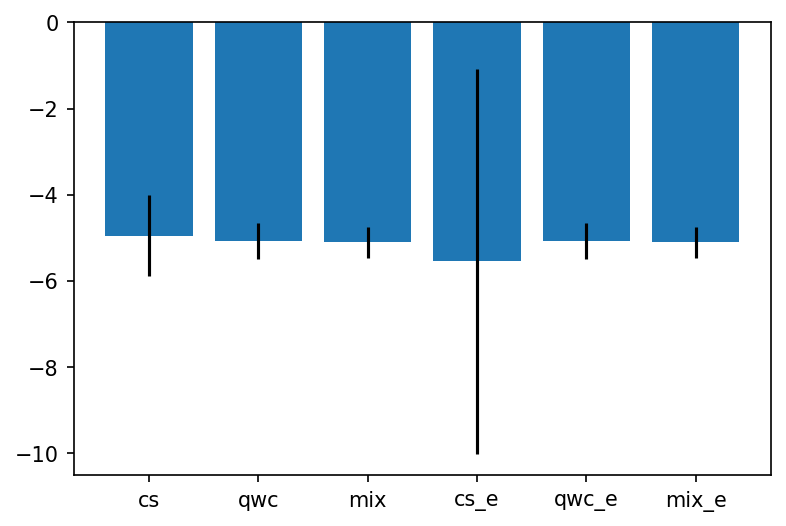

[ 1.00000000e+00+0.j  1.65445502e+00+0.j  7.33134353e+00+0.j
  7.33054243e+00+0.j  9.45901741e+01+0.j -1.36231052e+02+0.j
  2.06300695e+03+0.j -8.96237295e+03+0.j  6.77064459e+04+0.j
 -3.95875214e+05+0.j]
[ 1.00000000e+00+0.j  1.51901743e+00+0.j  7.43866953e+00+0.j
  5.58113656e+00+0.j  9.69188983e+01+0.j -1.54392484e+02+0.j
  2.08051046e+03+0.j -9.02445103e+03+0.j  6.69229177e+04+0.j
 -3.89230930e+05+0.j]
[ 1.00000000e+00+0.j  1.51901743e+00+0.j  7.96973096e+00+0.j
  1.69587732e+00+0.j  1.30919827e+02+0.j -3.86645912e+02+0.j
  3.69781929e+03+0.j -1.97154463e+04+0.j  1.37567529e+05+0.j
 -8.49862780e+05+0.j]
[ 1.00000000e+00+0.j  1.50475436e+00+0.j  7.63074485e+00+0.j
  4.53296305e+00+0.j  1.04551828e+02+0.j -2.00406540e+02+0.j
  2.38682788e+03+0.j -1.09686349e+04+0.j  7.95701082e+04+0.j
 -4.70622108e+05+0.j]
[ 1.00000000e+00+0.j  1.65451664e+00+0.j  7.25990491e+00+0.j
  7.74263099e+00+0.j  8.85296335e+01+0.j -9.54991902e+01+0.j
  1.75482872e+03+0.j -6.91991422e+03+0.j  5.39344715e+04+0

 -9.09606272e+05+0.j]
[ 1.00000000e+00+0.j  1.59033281e+00+0.j  6.83213593e+00+0.j
  9.99103718e+00+0.j  6.96873390e+01+0.j  2.40480907e+01+0.j
  9.42134011e+02+0.j -1.65344078e+03+0.j  1.94406219e+04+0.j
 -8.22980513e+04+0.j]
[ 1.00000000e+00+0.j  1.57606973e+00+0.j  6.92276751e+00+0.j
  6.66878283e+00+0.j  9.06179358e+01+0.j -1.45050114e+02+0.j
  2.05144678e+03+0.j -9.23463428e+03+0.j  6.89559199e+04+0.j
 -4.07536680e+05+0.j]
[ 1.00000000e+00+0.j  1.74720982e+00+0.j  7.24567545e+00+0.j
  7.52341886e+00+0.j  9.86974017e+01+0.j -1.71199646e+02+0.j
  2.35734816e+03+0.j -1.10175646e+04+0.j  8.19028103e+04+0.j
 -4.90146999e+05+0.j]
[ 1.00000000e+00+0.j  1.55707844e+00+0.j  6.99836293e+00+0.j
  7.22479624e+00+0.j  8.38740898e+01+0.j -8.74229343e+01+0.j
  1.62684136e+03+0.j -6.29049668e+03+0.j  4.91490839e+04+0.j
 -2.76589053e+05+0.j]
[ 1.00000000e+00+0.j  1.65844375e+00+0.j  7.36282762e+00+0.j
  5.86471741e+00+0.j  1.03642173e+02+0.j -2.09580162e+02+0.j
  2.54168131e+03+0.j -1.22336555e+04

/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


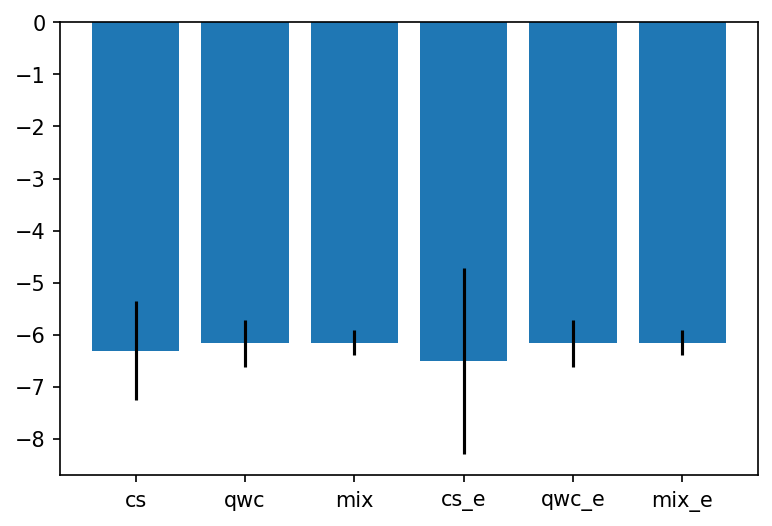

[ 1.00000000e+00+0.j  1.65445502e+00+0.j  7.33134353e+00+0.j
  7.33054243e+00+0.j  9.45901741e+01+0.j -1.36231052e+02+0.j
  2.06300695e+03+0.j -8.96237295e+03+0.j  6.77064459e+04+0.j
 -3.95875214e+05+0.j]
[ 1.00000000e+00+0.j  1.51901743e+00+0.j  7.43866953e+00+0.j
  5.58113656e+00+0.j  9.69188983e+01+0.j -1.54392484e+02+0.j
  2.08051046e+03+0.j -9.02445103e+03+0.j  6.69229177e+04+0.j
 -3.89230930e+05+0.j]
[ 1.00000000e+00+0.j  1.51901743e+00+0.j  7.96973096e+00+0.j
  1.69587732e+00+0.j  1.30919827e+02+0.j -3.86645912e+02+0.j
  3.69781929e+03+0.j -1.97154463e+04+0.j  1.37567529e+05+0.j
 -8.49862780e+05+0.j]
[ 1.00000000e+00+0.j  1.50475436e+00+0.j  7.63074485e+00+0.j
  4.53296305e+00+0.j  1.04551828e+02+0.j -2.00406540e+02+0.j
  2.38682788e+03+0.j -1.09686349e+04+0.j  7.95701082e+04+0.j
 -4.70622108e+05+0.j]
[ 1.00000000e+00+0.j  1.65451664e+00+0.j  7.25990491e+00+0.j
  7.74263099e+00+0.j  8.85296335e+01+0.j -9.54991902e+01+0.j
  1.75482872e+03+0.j -6.91991422e+03+0.j  5.39344715e+04+0

 -2.98611403e+05+0.j]
[ 1.00000000e+00+0.j  1.59020956e+00+0.j  7.10276460e+00+0.j
  8.71965160e+00+0.j  7.80437752e+01+0.j -1.92034110e+01+0.j
  1.21704992e+03+0.j -3.28961071e+03+0.j  2.98632643e+04+0.j
 -1.47886722e+05+0.j]
[ 1.00000000e+00+0.j  1.50475436e+00+0.j  8.30110935e+00+0.j
 -6.48969889e-01+0.j  1.43082409e+02+0.j -4.72951664e+02+0.j
  4.20888114e+03+0.j -2.30990800e+04+0.j  1.58908151e+05+0.j
 -9.88395953e+05+0.j]
[ 1.00000000e+00+0.j  1.53387994e+00+0.j  8.14301667e+00+0.j
  9.04030187e-01+0.j  1.36204716e+02+0.j -4.21723995e+02+0.j
  3.91719983e+03+0.j -2.11552491e+04+0.j  1.46774944e+05+0.j
 -9.09606272e+05+0.j]
[ 1.00000000e+00+0.j  1.59033281e+00+0.j  6.83213593e+00+0.j
  9.99103718e+00+0.j  6.96873390e+01+0.j  2.40480907e+01+0.j
  9.42134011e+02+0.j -1.65344078e+03+0.j  1.94406219e+04+0.j
 -8.22980513e+04+0.j]
[ 1.00000000e+00+0.j  1.57606973e+00+0.j  6.92276751e+00+0.j
  6.66878283e+00+0.j  9.06179358e+01+0.j -1.45050114e+02+0.j
  2.05144678e+03+0.j -9.23463428e+03

/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/numpy/ma/core.py:3379: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


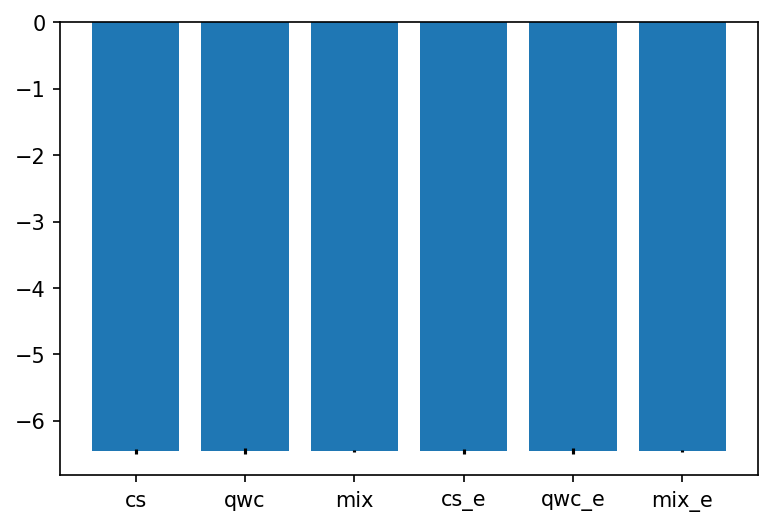

[ 1.00000000e+00+0.j  1.65445502e+00+0.j  7.33134353e+00+0.j
  7.33054243e+00+0.j  9.45901741e+01+0.j -1.36231052e+02+0.j
  2.06300695e+03+0.j -8.96237295e+03+0.j  6.77064459e+04+0.j
 -3.95875214e+05+0.j]


IndexError: index 10 is out of bounds for axis 0 with size 10

In [126]:
# moment data analysis
for i in range(2*K):
    cs_moments = [complex(s) for s in data["cs_moments"][i]]
    qwc_moments = [complex(s) for s in data["qwc_moments"][i]]
    mix_moments = [complex(s) for s in data["mix_moments"][i]]
    plt.bar(["cs","qwc","mix"],[np.mean(cs_moments), np.mean(qwc_moments), np.mean(mix_moments)], 
           yerr = [np.std(cs_moments), np.std(qwc_moments), np.std(mix_moments)])
    print([i, np.std(cs_moments), np.mean(qwc_moments), np.mean(mix_moments)])
    plt.show()
cs_moments = np.array([[complex(s) for s in data["cs_moments"][i]] for i in range(2*K)])
qwc_moments = np.array([[complex(s) for s in data["qwc_moments"][i]] for i in range(2*K)])
mix_moments = np.array([[complex(s) for s in data["mix_moments"][i]] for i in range(2*K)])
for i in range(6):
    cs_e = []
    qwc_e = []
    mix_e = []
    for n_ in range(n_points):
        print(cs_moments[:,n_])
        cs_e += [comp_energy(cs_moments[:,n_], i+1)]
        qwc_e += [comp_energy(qwc_moments[:,n_], i+1)]
        mix_e += [comp_energy(mix_moments[:,n_], i+1)]
    cs_energy = [complex(s) for s in data_no_outliers["cs_energy"][i]]
    qwc_energy = [complex(s) for s in data_no_outliers["qwc_energy"][i]]
    mix_energy = [complex(s) for s in data_no_outliers["mix_energy"][i]]
    plt.bar(["cs","qwc","mix", "cs_e", "qwc_e", "mix_e"],[np.mean(cs_energy), np.mean(qwc_energy), np.mean(mix_energy), np.mean(cs_e), np.mean(qwc_e), np.mean(mix_e)], 
           yerr = [np.std(cs_energy), np.std(qwc_energy), np.std(mix_energy), np.std(cs_e), np.std(qwc_e), np.std(mix_e)])
    plt.show()